# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['EnsembleTimeInvariant']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import SymPy and set up latex inline & pretty dict printing
from sympy import Matrix, Eq, rad, init_printing
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import e2d, convert, omitdict
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import eta, mu, Lc, Ci, varepsilon, varepsilonhat, \
                             xiv_0, xih_0, beta_0
from gme.core.equations import Equations
from gme.core.equations_subset import EquationSubset
from gme.ode.time_invariant import TimeInvariantSolution
from gme.ode.utils import integrate_dzdx
from gme.plot.time_invariant import TimeInvariant

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme)
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['EnsembleTimeInvariant'])

### Parameter parsing

In [4]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/RayTracing/EnsembleTimeInvariant.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


{   'debug': False,
    'group_name': 'TimeInvariantSolutions',
    'short_name': 'tis',
    'subtitle': '',
    'title': 'Ensemble of time-invariant profiles',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Ci_list': [pi/1800, pi/180, pi/45],
    'Lc': 10000,
    'Lc_list': [10000.0, 10000.0, 10000.0],
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'eta_list': [3/2, 1/2],
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    'mu_list': [3/4, 1/4],
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varepsilonhat_list': [1/100, 1/100, 1/100],
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_dist

In [5]:
# Create a dict of the key physics parameters to be used in substitutions
pr_choices = {}
for (eta_,mu_),(Ci_,varepsilonhat_,Lc_) in \
    zip(list(zip(pr.model.eta_list, pr.model.mu_list))*len(pr.model.Ci_list),
        list(zip(pr.model.Ci_list, pr.model.varepsilonhat_list, pr.model.Lc_list))
            *len(pr.model.eta_list)):
    pr_choices.update({(eta_,Ci_): {eta:eta_,
                                    mu:mu_, 
                                    Ci:Ci_,
                                    varepsilonhat:varepsilonhat_, 
                                    varepsilon:varepsilonhat_*Lc_, 
                                    Lc:Lc_}})
pr_choices.keys()

dict_keys([(3/2, pi/1800), (1/2, pi/180), (3/2, pi/45), (1/2, pi/1800), (3/2, pi/180), (1/2, pi/45)])

# Equations

Derive the GME equation set (using SymPy) for a specific erosion model.

In [6]:
gmeq = {}
for eta_,mu_ in zip(pr.model.eta_list, pr.model.mu_list):
    print(eta_,mu_, mu_/eta_, flush=True)
    gmeq[eta_] = Equations( eta_=eta_, 
                            mu_=mu_, 
                            beta_type=pr.model.beta_type, 
                            varphi_type=pr.model.varphi_type, 
#                             ibc_type=pr.model.ibc_type,
                            parameters=pr_choices[eta_,rad(1)], 
                            do_raw=True )
gmeq

3/2 3/4 1/2


gme.core.equations.Equations
gme.core.equations.EquationsMixedIn
gme.core.equations.EquationsBase
gme.core.rp.define_p_eqns
gme.core.rp.define_r_eqns
gme.core.xi.define_xi_eqns
gme.core.xi.define_xi_model_eqn
gme.core.xi.define_xi_related_eqns
gme.core.varphi.define_varphi_model_eqns
gme.core.varphi.define_varphi_related_eqns
gme.core.fundamental.define_Fstar_eqns
gme.core.fundamental.define_H_eqns
gme.core.hamiltons.define_rdot_eqns
gme.core.hamiltons.define_pdot_eqns
gme.core.hamiltons.define_Hamiltons_eqns
gme.core.ndim.nondimensionalize
gme.core.ndim.define_nodimensionalized_Hamiltons_eqns
gme.core.profile.define_z_eqns
gme.core.angles.define_tanalpha_eqns
gme.core.angles.define_tanbeta_eqns
gme.core.angles.define_psi_eqns
gme.core.metrictensor.define_g_eqns
gme.core.pxpoly.define_px_poly_eqn (ndim=False)
gme.core.pxpoly.define_px_poly_eqn (ndim=True)


1/2 1/4 1/2


gme.core.equations.Equations
gme.core.equations.EquationsMixedIn
gme.core.equations.EquationsBase
gme.core.rp.define_p_eqns
gme.core.rp.define_r_eqns
gme.core.xi.define_xi_eqns
gme.core.xi.define_xi_model_eqn
gme.core.xi.define_xi_related_eqns
gme.core.varphi.define_varphi_model_eqns
gme.core.varphi.define_varphi_related_eqns
gme.core.fundamental.define_Fstar_eqns
gme.core.fundamental.define_H_eqns
gme.core.hamiltons.define_rdot_eqns
gme.core.hamiltons.define_pdot_eqns
gme.core.hamiltons.define_Hamiltons_eqns
gme.core.ndim.nondimensionalize
gme.core.ndim.define_nodimensionalized_Hamiltons_eqns
gme.core.profile.define_z_eqns
gme.core.angles.define_tanalpha_eqns
gme.core.angles.define_tanbeta_eqns
gme.core.angles.define_psi_eqns
gme.core.metrictensor.define_g_eqns
gme.core.pxpoly.define_px_poly_eqn (ndim=False)
gme.core.pxpoly.define_px_poly_eqn (ndim=True)


{3/2: <gme.core.equations.Equations at 0x1446682b0>,
 1/2: <gme.core.equations.Equations at 0x144e96520>}

# Integration

### Ray tracing

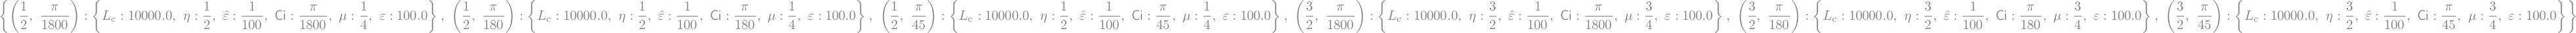

In [7]:
pr_choices

In [8]:
gmes = {}

for eta_,Ci_ in pr_choices:
    print(eta_,Ci_)
    sub_ = pr_choices[(eta_,Ci_)]
    mu_ = sub_[mu]
    
    gmeq_ = gmeq[eta_]
    
    beta0_ = float(
        beta_0.subs(e2d(gmeq_.beta0_Ci_eqn.subs(omitdict(sub_,[beta_0]))))
        )
    sub_.update({beta_0:beta0_})
    print(convert(Eq(beta_0, beta0_), n=2, units=degrees, do_raw=False))
    
    xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq_.xiv0_xih0_Ci_eqn)).subs(sub_))
    sub_.update({(xiv_0/xih_0):xivh0_})
    print(Eq(xiv_0/xih_0, sub_[xiv_0/xih_0]))
    print()
    
    gmeq_ndim_subset_ = EquationSubset(gmeq_, 
                                        sub_, 
                                        do_ndim=True, 
                                        do_revert=True) 
    Matrix([
        gmeq_ndim_subset_.pz_xiv_eqn,
        gmeq_ndim_subset_.poly_px_xiv0_eqn,
        gmeq_ndim_subset_.xiv0_xih0_Ci_eqn
    ])
    
    xmax_ = 0.999
    
    gmes_ = TimeInvariantSolution( gmeq_ndim_subset_, parameters=sub_, 
                                  t_end=pr.solve.t_end, 
                                  t_distribn=pr.solve.t_distribn, 
                                  x_stop=xmax_,
                                  n_t=pr.solve.ray_n_t,
                                  choice=pr.solve.choice, 
                                  method=pr.solve.method[pr.solve.choice],
                                  do_dense=pr.solve.do_dense )
    
    gmes_.initial_conditions()
    gmes_.solve()

    soln = gmes_.ivp_solns_list[0]
    print(f'Number of ray-traced solutions: {len(gmes_.ivp_solns_list)}\n\n'
          f'Message: {soln.message}\nSuccess? {soln.success}',
          f'\nStatus:{soln.status}\nt_final: {soln.t[-1]}\n'
          +f'rx_final: {soln.y[0][-1]}')
    
    gmes_.postprocessing(spline_order=pr.resolve.spline_order)
    gmes_.integrate_h_profile(do_truncate=True, x_max=1)
    
    gmes.update({(eta_,Ci_):gmes_})

gme.core.equations_subset.EquationSubset


3/2 pi/1800
Eq(\beta_0, 0.1*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.00169400094742009)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 3.0250000000000004
rx_final: 0.9985724005422089


gme.core.equations_subset.EquationSubset


1/2 pi/180
Eq(\beta_0, 1.01*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0176296695601045)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 7.861777777777778
rx_final: 0.9984442738511575


gme.core.equations_subset.EquationSubset


3/2 pi/45
Eq(\beta_0, 3.88*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0678606600885215)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 4.900000000000001
rx_final: 0.9988503334716711


gme.core.equations_subset.EquationSubset


1/2 pi/1800
Eq(\beta_0, 0.1*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.00176278438839677)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 9.088444444444445
rx_final: 0.9989800129556464


gme.core.equations_subset.EquationSubset


3/2 pi/180
Eq(\beta_0, 0.97*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0169415644775999)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 3.3640000000000008
rx_final: 0.9989053404854338


gme.core.equations_subset.EquationSubset


1/2 pi/45
Eq(\beta_0, 4.04*degree)
Eq(\xi^{\downarrow_{0}}/\xi^{\rightarrow_{0}}, 0.0706295510311555)



gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration
gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>
<class 'sympy.core.mul.Mul'>


gme.core.time_invariant.postprocessing
gme.core.time_invariant.integrate_h_profile


Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 5.929
rx_final: 0.9979021407877275


### Direct

3/2 pi/1800
1/2 pi/180
3/2 pi/45
1/2 pi/1800
3/2 pi/180
1/2 pi/45


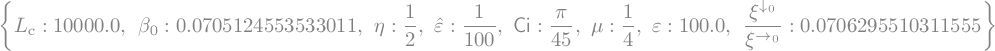

In [9]:
xivhat0_ = 1
for eta_,Ci_ in pr_choices:
    print(eta_,Ci_)
    gmes_ = gmes[(eta_,Ci_)]
    sub_ = pr_choices[(eta_,Ci_)]
    (gmes_.h_x_direct_array, gmes_.h_z_direct_array) \
        = integrate_dzdx(gmeq=gmeq[eta_], sub_=sub_)
sub_

In [10]:
gmeq_ = gmeq[eta_]
eta_

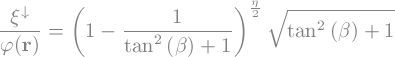

In [11]:
gmeq_.xiv_eqn

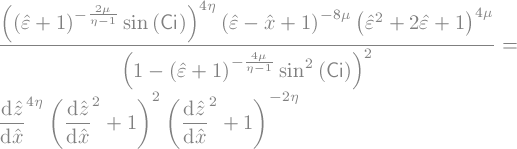

In [12]:
gmeq_.dzdx_Ci_polylike_prelim_eqn

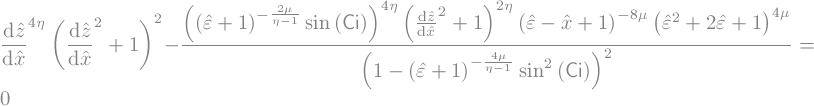

In [13]:
gmeq_.dzdx_Ci_polylike_eqn

# Plots

Visualization of results

## Preliminaries

In [14]:
gr = TimeInvariant()

In [15]:
prefix = pr.job.short_name

suffix = '_profile_ensemble'
# suffix  = f'_eta{float(sy.N(pr.model.eta))}'
# suffix += f'_Ci{float(sy.N(sy.deg(Ci_)))}'
# suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
# suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}')

job_name = prefix+suffix.replace('.','p')
job_name

'tis_profile_ensemble'

## Graphs

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

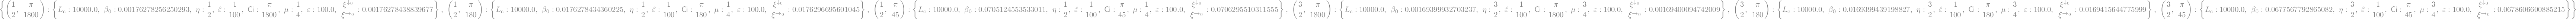

In [16]:
pr_choices

gmplib.plot.GraphingBase:
   Creating plot: tis_profile_ensemble_h size=(10, 7) @ 100 dpi


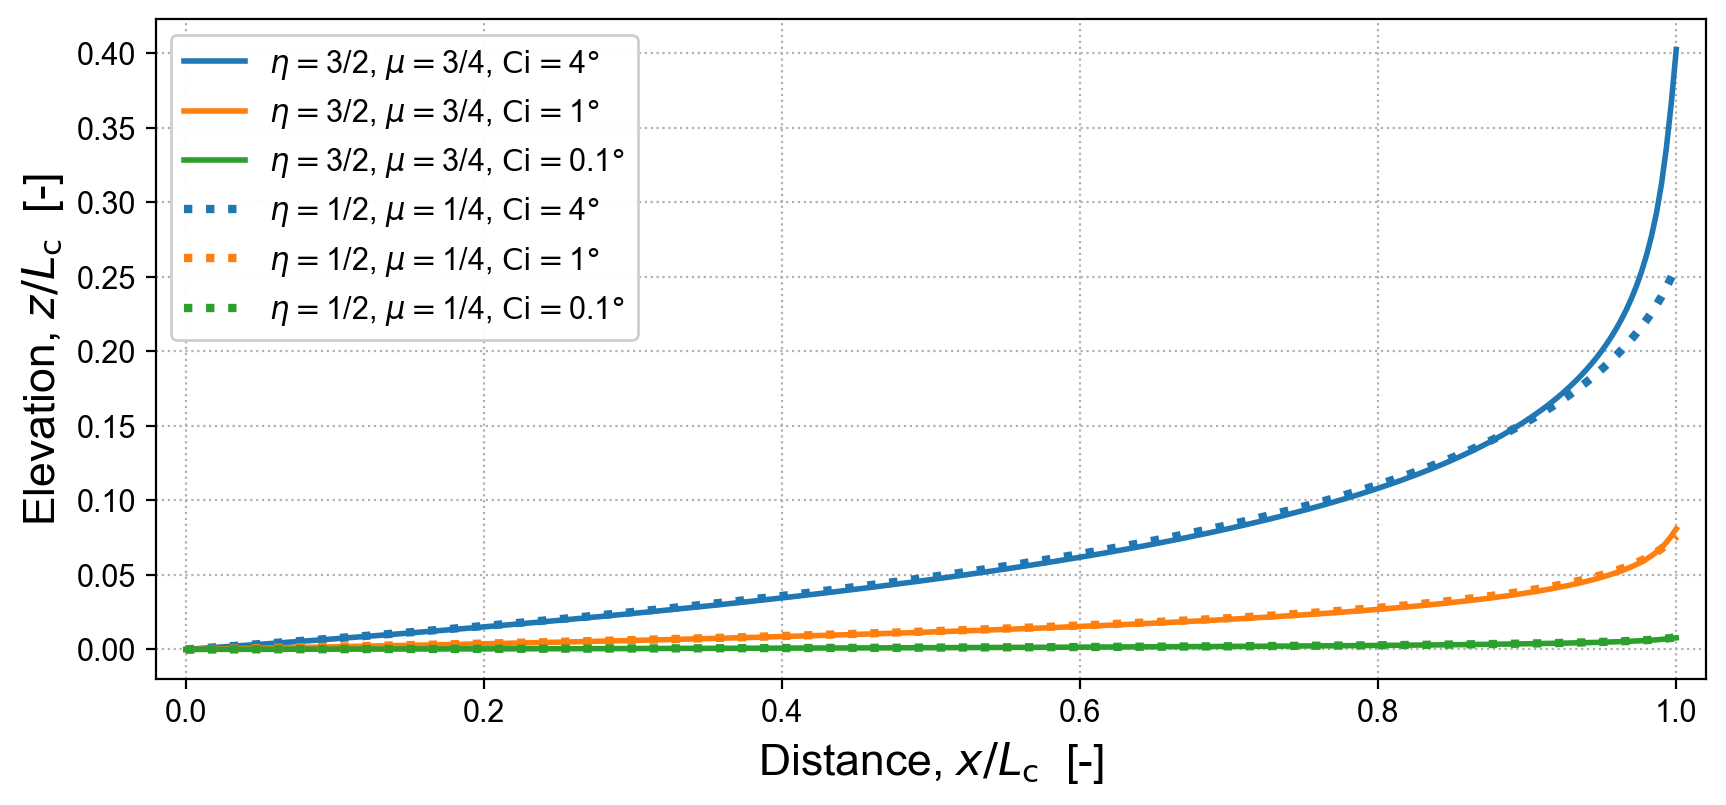

In [17]:
gr.profile_ensemble( gmes, pr_choices, job_name+'_h', fig_size=(10,7) )

gmplib.plot.GraphingBase:
   Creating plot: tis_profile_ensemble_h_direct size=(10, 7) @ 100 dpi


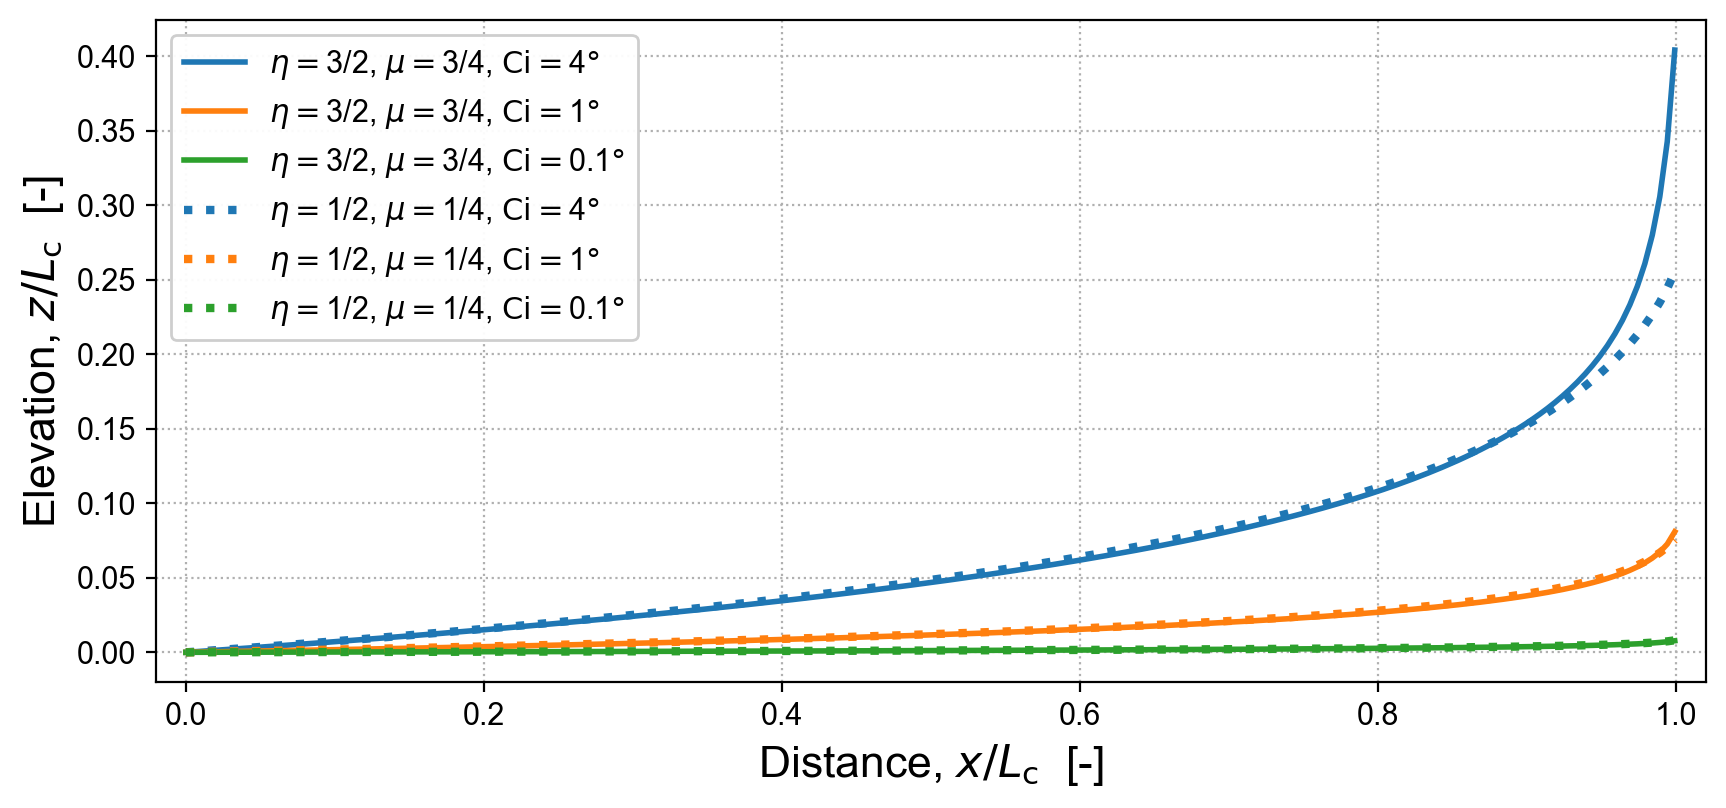

In [18]:
gr.profile_ensemble(gmes, 
                    pr_choices, 
                    job_name+'_h_direct', 
                    do_direct=True,
                    fig_size=(10,7))

# Save

Export the graphs as PNG and/or PDF image files.

In [19]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, 
              file_types=pr.save.figs_format, 
              dpi=pr.save.figs_options['dpi'] )

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
gmplib.save.export_plot: Exported "tis_profile_ensemble_h.jpg"
gmplib.save.export_plot: Exported "tis_profile_ensemble_h_direct.jpg"
gmplib.save.export_plot: Exported "tis_profile_ensemble_h.pdf"
gmplib.save.export_plot: Exported "tis_profile_ensemble_h_direct.pdf"
